In [1]:
# Pour que les changements dans les modules importés (bandits.py) soient pris en compte
%load_ext autoreload
%autoreload 2
# Pour afficher les figures dans le notebook
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Changement des paramètres d'affichage par défaut
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 20, 10
mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['font.size'] = 24
mpl.rcParams['lines.markersize'] = 15
mpl.rcParams['axes.grid'] = True
# mpl.rcParams.find_all('')

In [72]:
try:
    # Pour utiliser la correction (prof)
    import bandits_correction as bandits
    import exp_correction
    print('Correction importée')
except:
    # Pour utiliser le code fourni à compléter (étudiants)
    import bandits

In [5]:
# Création d'un problème avec 4 bras
bandits_pb = bandits.BernoulliMultiArmedBandits(means = [0.1, 0.85, 0.7, 0.849])
print(bandits_pb)

4-arms bandit problem with Bernoulli distributions


# Les algorithmes de bandits: la classe abstraite `BanditAlgorithm`
Dans `bandits.py`, on fournit une classe abstraite `BanditAlgorithm` générique pour les algorithmes de bandits:
* la méthode abstraite `get_action()` renvoie l'action choisie
* la méthode `fit_step(a, r)` prend en argument une action `a` et une récompense `r` obtenue suite à cette action pour apprendre à partir de cet exemple, par exemple en mettant à jour les estimations des valeurs des bras.  Plusieurs sous-classes sont proposées pour les différentes stratégies de résolution.

La plupart des algorithmes doivent mettre à jour le nombre de tirages $N(a)$ de chaque bras $a$ et sa récompense moyenne $Q(a)$: ces valeurs sont stockées sous forme de tableaux numpy dans les attributs `_n_estimates` et `_value_estimates` , respectivement.

# Exploration pure: stratégie aléatoire

On utilise ici la classe `RandomBanditAlgorithm` qui implémente un algorithme de bandit qui choisit une action totalement aléatoirement, sans rien apprendre.

**À faire.** Étudiez le code de cette classe (constructeur, méthodes à `get_action` et `fit_step`).

**À faire sur papier.** Calculez le gain moyen de ce joueur en fonction des vraies valeurs des bras. 9.371


Le code ci-dessous est une simulation classique de l'interaction entre un algorithme de bandit et son environnement: choix du bras, récompense, entrainement online.

In [7]:
# Création de l'algo
rand_algo = bandits.RandomBanditAlgorithm(n_arms=bandits_pb.n_arms)
# On choisit un bras et on observe la récompense, le tout 15 fois
for i in range(15):
    i_arm = rand_algo.get_action()  # Choix du bras par l'algo
    r = bandits_pb.step(i_arm)  # Récompense obtenue
    rand_algo.fit_step(action=i_arm, reward=r)  # mise à jour de l'algo
    print('Bras {} -> récompense {}'.format(i_arm, r))

Bras 2 -> récompense True
Bras 1 -> récompense False
Bras 3 -> récompense False
Bras 2 -> récompense True
Bras 0 -> récompense False
Bras 1 -> récompense True
Bras 1 -> récompense True
Bras 0 -> récompense False
Bras 3 -> récompense True
Bras 3 -> récompense True
Bras 2 -> récompense True
Bras 2 -> récompense False
Bras 2 -> récompense True
Bras 1 -> récompense False
Bras 2 -> récompense True


In [14]:
# On cherche à tracer le regret sur un grand nombre d'itérations
n_draws = 10**4  # On pourra augmenter ce nombre à 10**5 une fois que le code fonctionne bien pour aller plus loin dans les itérations

# Simulation
rand_algo = bandits.RandomBanditAlgorithm(n_arms=bandits_pb.n_arms)
rewards_rand = np.empty(n_draws)
selected_arms_rand = np.empty(n_draws)
for i in range(n_draws):
    i_arm = rand_algo.get_action()  # Choix du bras par l'algo
    r = bandits_pb.step(i_arm)  # Récompense obtenue #environment
    rand_algo.fit_step(action=i_arm, reward=r)  # mise à jour de l'algo
    rewards_rand[i] = r
    selected_arms_rand[i] = i_arm
# Calcul du regret sur une simu
r_max = np.max(bandits_pb._true_values)  # Gain moyen du bras optimal # le bras optimal est tj le meme pour le algo random
cum_reward_rand = np.cumsum(rewards_rand)  # Récompenses cumulées
regret_rand = np.arange(1, n_draws+1) * r_max - cum_reward_rand# Regret random


In [41]:
print(rewards_rand)
print(np.cumsum(rewards_rand))
print(r_max)
print(regret_rand)
print(cum_reward_rand[1000])

[0. 0. 0. ... 1. 0. 0.]
[   0.    0.    0. ... 6277. 6277. 6277.]
0.85
[8.50000e-01 1.70000e+00 2.55000e+00 ... 2.22130e+03 2.22215e+03
 2.22300e+03]
638.0


In [39]:
v = [0,1,1,0]
c = np.cumsum(v)

In [40]:
c

array([0, 1, 2, 2], dtype=int32)

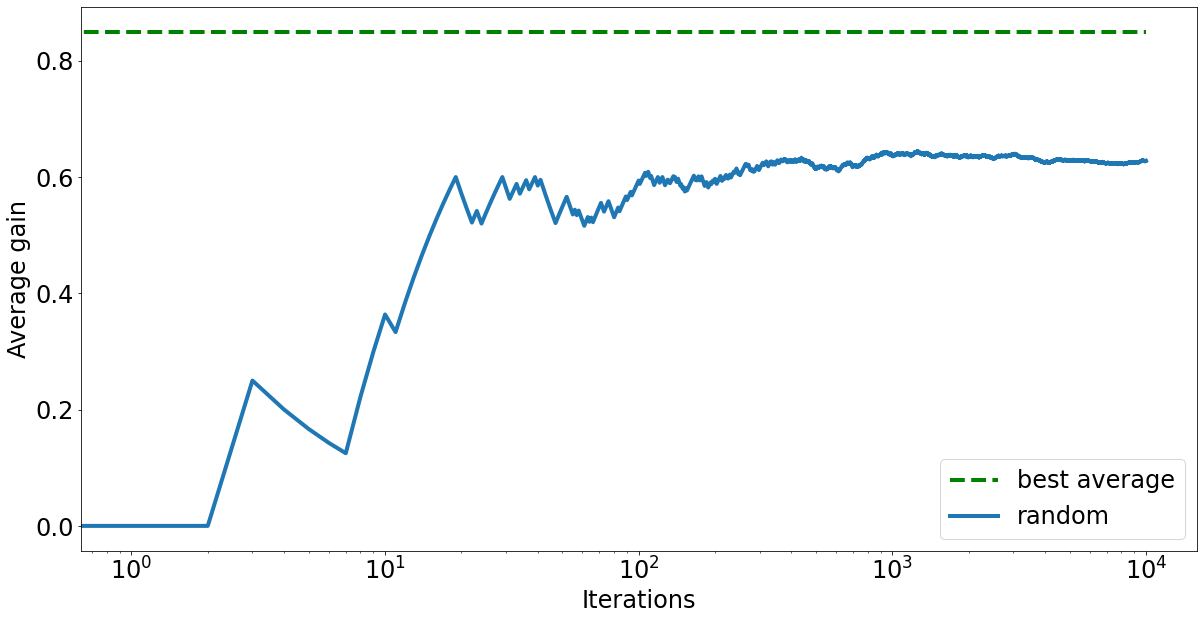

In [16]:
# On trace le gain moyen en fonction des itérations
plt.semilogx([0, n_draws-1], [r_max, r_max], '--g', label='best average')
plt.semilogx(cum_reward_rand / np.arange(1, n_draws+1), label='random') # gain moyene per iteration 
plt.xlabel('Iterations')
plt.ylabel('Average gain')
plt.grid()
plt.legend()

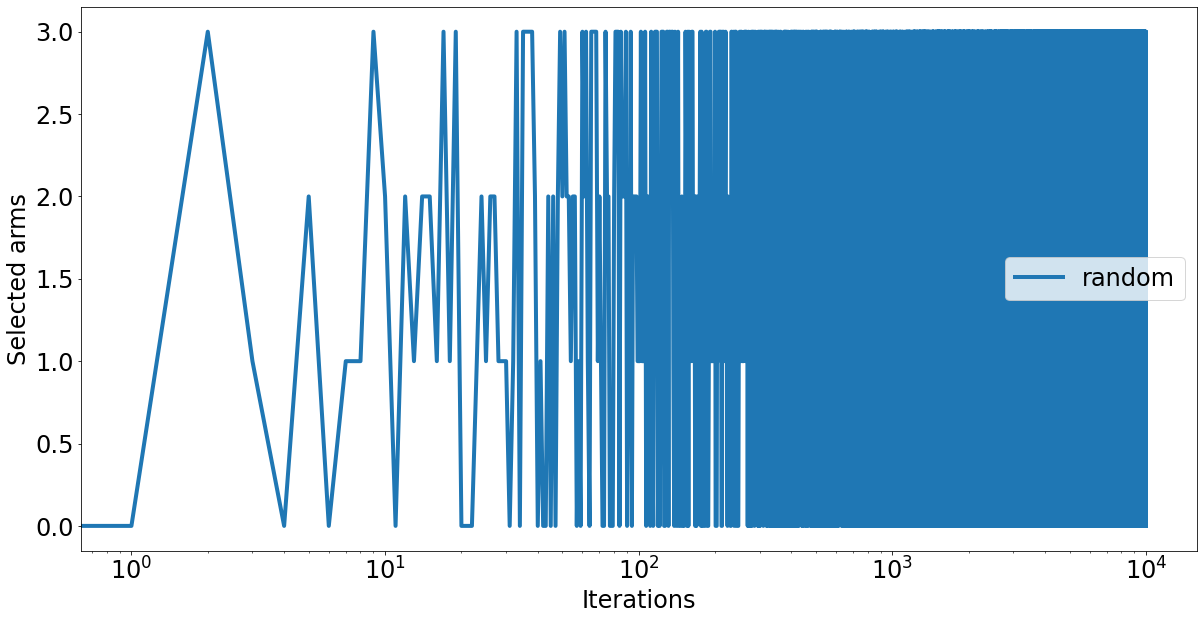

In [19]:
# Les bras sélectionnés
plt.semilogx(selected_arms_rand, label='random')
plt.xlabel('Iterations')
plt.ylabel('Selected arms')
plt.legend()
plt.grid()

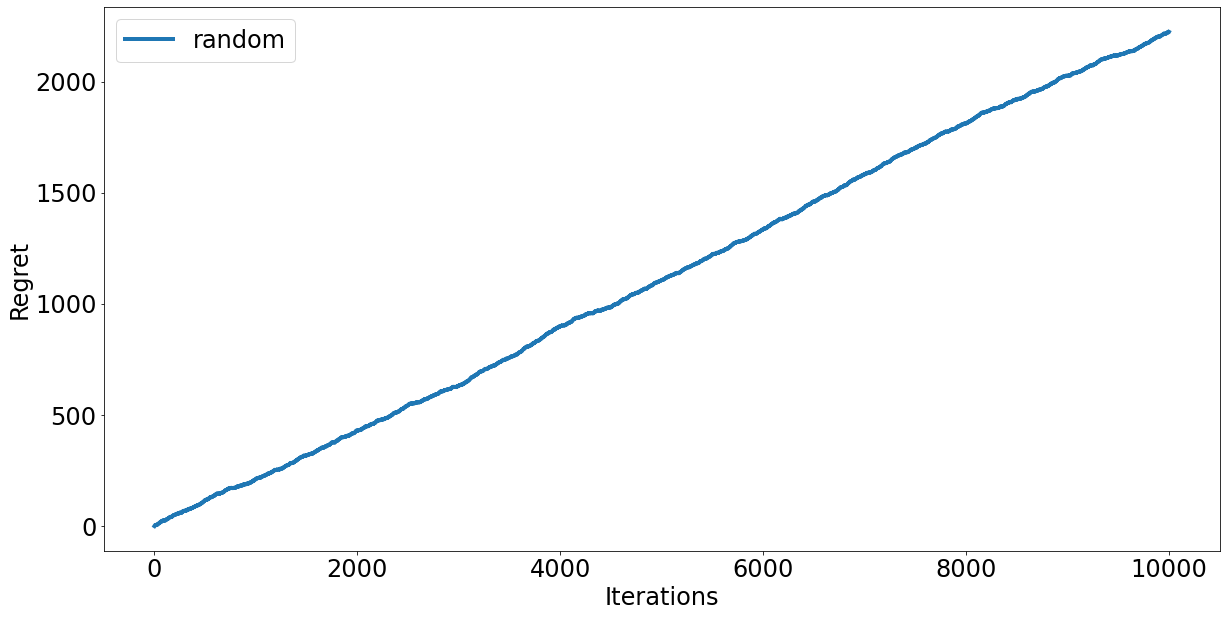

In [20]:
# Le regret sur une simu
plt.plot(regret_rand, label='random')
plt.xlabel('Iterations')
plt.ylabel('Regret')
plt.grid()
plt.legend()

# Exploitation pure: stratégie greedy

**Question à chercher sur papier.** On cherche à mettre à jour les moyennes des gains de chaque bras de façon online. Pour tout $n>0$, on note $\mu_n=\frac{1}{n}\sum_{i=1}^{n} x_i$ la moyenne de $n$ valeurs $x_i$, avec $\mu_0=0$. Montrer mathématiquement que pour tout $n>1$, on a $\mu_n = \mu_{n-1} + \frac{1}{n} \left (x_n - \mu_{n-1}\right )$.

**À faire.** En utilisant la formule précédentes, complétez la méthode `fit_step` de la classe `GreedyBanditAlgorithm` puis implémentez sa méthode `get_action`.

In [26]:
# Création de l'algo
greedy_algo = bandits.GreedyBanditAlgorithm(n_arms=bandits_pb.n_arms)
# On choisit un bras et on observe la récompense, le tout 15 fois
for i in range(15):
    i_arm = greedy_algo.get_action()  # Choix du bras par l'algo
    r = bandits_pb.step(i_arm)  # Récompense obtenue
    greedy_algo.fit_step(action=i_arm, reward=r)  # mise à jour de l'algo
    print('Bras {} -> récompense {}'.format(i_arm, r))

Bras 0 -> récompense False
Bras 1 -> récompense True
Bras 2 -> récompense False
Bras 3 -> récompense True
Bras 1 -> récompense False
Bras 3 -> récompense True
Bras 3 -> récompense True
Bras 3 -> récompense True
Bras 3 -> récompense True
Bras 3 -> récompense False
Bras 3 -> récompense True
Bras 3 -> récompense True
Bras 3 -> récompense True
Bras 3 -> récompense False
Bras 3 -> récompense False


In [27]:
# Une simulation sur un grand nombre d'itérations
np.random.seed(3)
greedy_algo = bandits.GreedyBanditAlgorithm(n_arms=bandits_pb.n_arms)
rewards_greedy = np.empty(n_draws)
selected_arms_greedy = np.empty(n_draws)
for i in range(n_draws):
    i_arm = greedy_algo.get_action()  # Choix du bras par l'algo
    r = bandits_pb.step(i_arm)  # Récompense obtenue
    greedy_algo.fit_step(action=i_arm, reward=r)  # mise à jour de l'algo
    rewards_greedy[i] = r
    selected_arms_greedy[i] = i_arm
cum_reward_greedy = np.cumsum(rewards_greedy)  # Récompenses cumulées


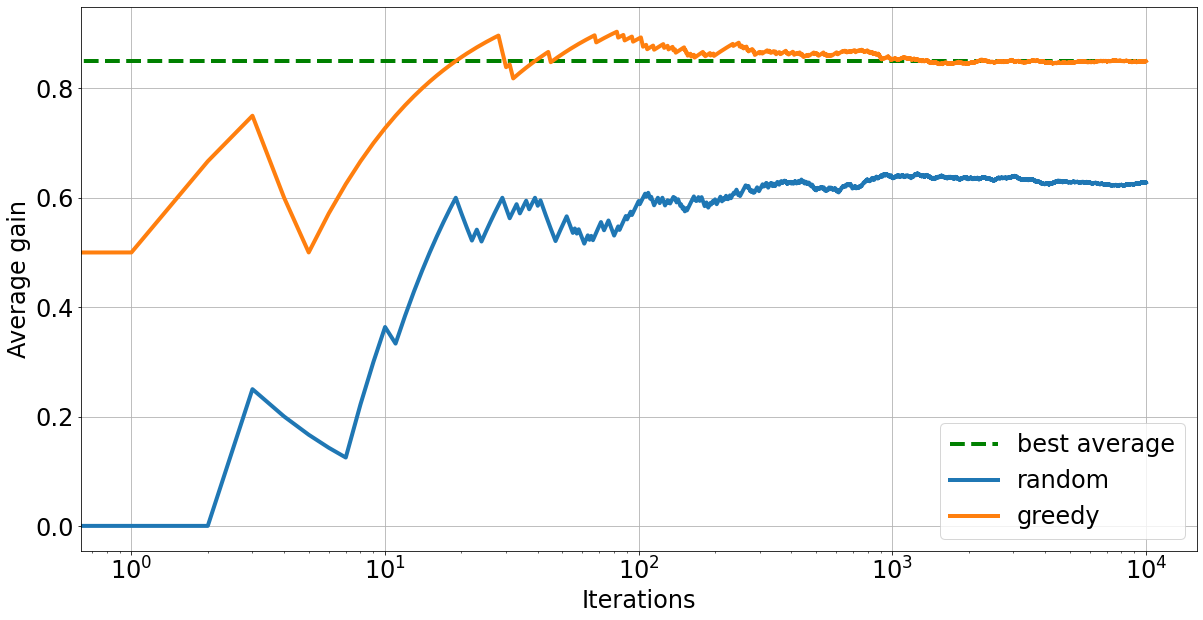

In [28]:
# On trace le gain moyen en fonction des itérations
plt.semilogx([0, n_draws-1], [r_max, r_max], '--g', label='best average')
plt.semilogx(cum_reward_rand / np.arange(1, n_draws+1), label='random')
plt.semilogx(cum_reward_greedy / np.arange(1, n_draws+1), label='greedy')
plt.xlabel('Iterations')
plt.ylabel('Average gain')
plt.legend()

[0.1   0.85  0.7   0.849]
[0.         0.5        0.5        0.84972486]


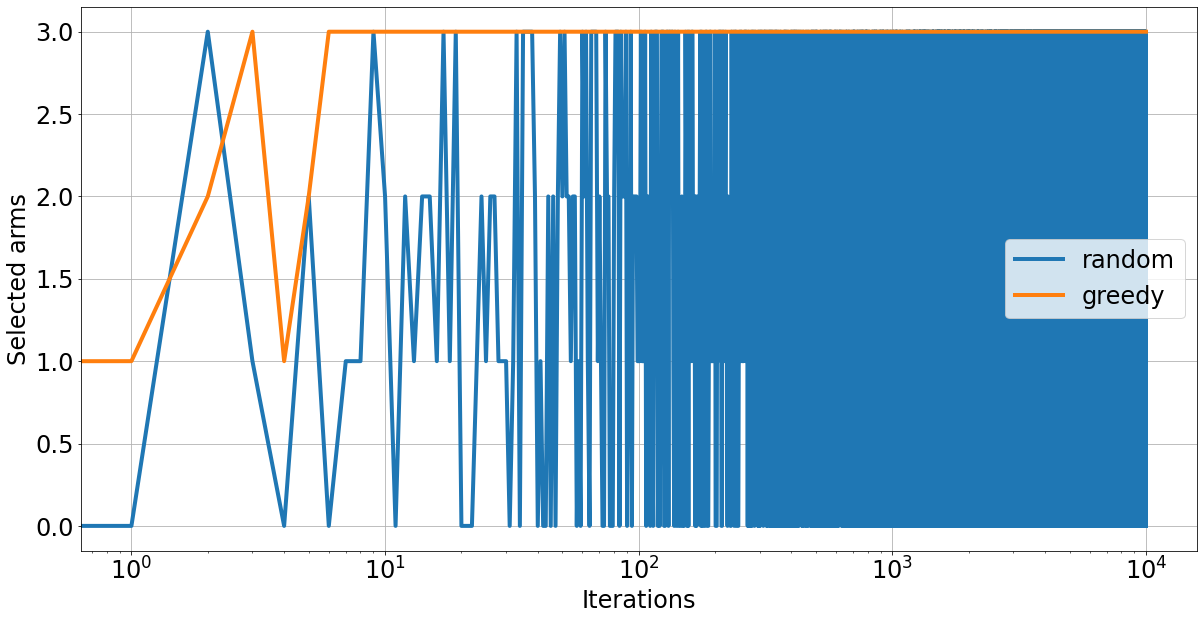

In [30]:
plt.semilogx(selected_arms_rand, label='random')
plt.semilogx(selected_arms_greedy, label='greedy')
plt.xlabel('Iterations')
plt.ylabel('Selected arms')
plt.legend()
print(bandits_pb._means)
print(greedy_algo._value_estimates)

**À faire.** La stratégie greedy peut rester piégée dans un mauvais choix. Répétez l'expérience précédente un grand nombre de fois (50) en réinitialisant l'algorithme à chaque fois; calculer ensuite un regret empirique en faisant des moyennes par rapport à toutes les initialisations de l'algorithme et tracez-le.

In [61]:
regrets = []
bras_opti = []
for j in range(50):
    # Une simulation sur un grand nombre d'itérations
    np.random.seed(j) # Si on ne fait pas ça il va tj donné les memes valeurs (choix du bras/ recompense)
    greedy_algo = bandits.GreedyBanditAlgorithm(n_arms=bandits_pb.n_arms)
    rewards_greedy = np.empty(n_draws)
    selected_arms_greedy = np.empty(n_draws)
    for i in range(n_draws):
        i_arm = greedy_algo.get_action()  # Choix du bras par l'algo
        r = bandits_pb.step(i_arm)  # Récompense obtenue
        greedy_algo.fit_step(action=i_arm, reward=r)  # mise à jour de l'algo
        rewards_greedy[i] = r
        selected_arms_greedy[i] = i_arm
    
    # Calcul du regret sur une simu
    r_max = np.max(greedy_algo._value_estimates)  # Gain moyen du bras optimal au fin du simu (on utilize Q, pas true_values)
    cum_reward_greedy = np.cumsum(rewards_greedy)  # Récompenses cumulées
    regret_greedy = np.arange(1, n_draws+1) * r_max - cum_reward_greedy
    regrets.append(regret_greedy)
    arm = greedy_algo.get_action()
    bras_opti.append(arm) # Sauvegarder le bras optimale au find e chaque simu
    


In [62]:
regret_moyanne = np.mean(regrets, axis=0)

In [63]:
regret_moyanne

array([0.71176443, 0.72352885, 0.97529328, ..., 2.52072888, 2.5324933 ,
       2.46425773])

In [64]:
greedy_algo._value_estimates

array([0.        , 0.85535661, 0.        , 0.        ])

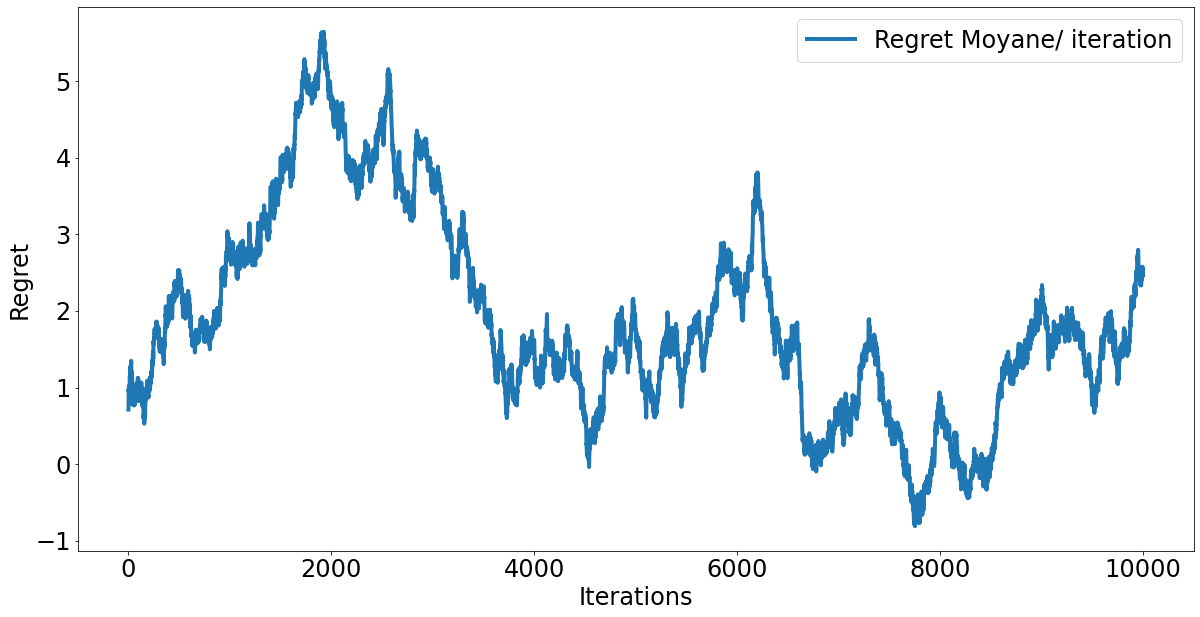

In [65]:
# Le regret moyanne (empirique) sur 50 simus
plt.plot(regret_moyanne, label='Regret Moyane/ iteration')
plt.xlabel('Iterations')
plt.ylabel('Regret')
plt.grid()
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


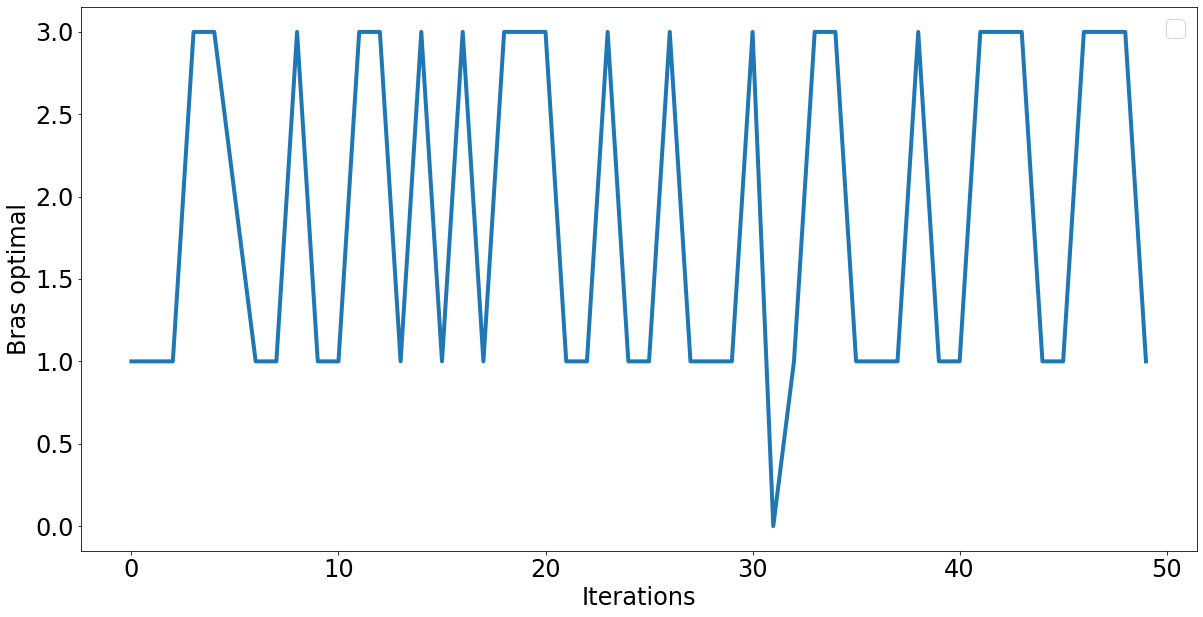

In [69]:

# Le bras optimal au fin de chaque simu, sur 50 simus
plt.plot(bras_opti)
plt.xlabel('Iterations')
plt.ylabel('Bras optimal')
plt.grid()
plt.legend()

In [31]:
# Correction
try:
    my_vars = dict()
    my_vars['bandits_pb'] = bandits_pb
    my_vars['n_draws'] = n_draws
    my_vars['regret_rand'] = regret_rand
    my_vars['cum_reward_rand'] = cum_reward_rand
    exp_correction.exp_greedy(my_vars)
except:
    print("Ignorer cette cellule, elle ne sert qu'à l'enseignant!")

Ignorer cette cellule, elle ne sert qu'à l'enseignant!


 # Stratégie $\epsilon$-greedy
**À faire.** Complétez les méthodes `fit_step` et `get_action` de la classe `EpsilonGreedyBanditAlgorithm`, réalisez l'expérience précédente dans le cas de la stratégie $\epsilon$-greedy et tracez les résultats de toutes les stratégies en les superposant. Vous pourrez fixer $\epsilon=0.01$ dans un premier temps. Tester ensuite plusieurs valeurs de $\epsilon$ telles que $\epsilon=0.1$ et $\epsilon=0$, superposez les courbes et commentez-les.

##### Tests

In [99]:
# Création de l'algo
epsilon_algo = bandits.EpsilonGreedyBanditAlgorithm(n_arms=bandits_pb.n_arms, epsilon=0.1)
# On choisit un bras et on observe la récompense, le tout 15 fois
for i in range(15):
    i_arm = epsilon_algo.get_action()  # Choix du bras par l'algo
    r = bandits_pb.step(i_arm)  # Récompense obtenue
    epsilon_algo.fit_step(action=i_arm, reward=r)  # mise à jour de l'algo
    print('Bras {} -> récompense {}'.format(i_arm, r))

Bras 0 -> récompense True
Bras 1 -> récompense True
Bras 2 -> récompense True
Bras 3 -> récompense True
Bras 0 -> récompense False
Bras 1 -> récompense False
Bras 2 -> récompense True
Bras 2 -> récompense True
Bras 2 -> récompense True
Bras 2 -> récompense True
Bras 2 -> récompense False
Bras 3 -> récompense True
Bras 3 -> récompense True
Bras 3 -> récompense False
Bras 3 -> récompense False


In [115]:
# Une simulation sur un grand nombre d'itérations
np.random.seed(3)
epsilon_algo = bandits.EpsilonGreedyBanditAlgorithm(n_arms=bandits_pb.n_arms, epsilon=0) # 0.1 0.01, 0
rewards_epsilon = np.empty(n_draws)
selected_arms_epsilon = np.empty(n_draws)
for i in range(n_draws):
    i_arm = epsilon_algo.get_action()  # Choix du bras par l'algo
    r = bandits_pb.step(i_arm)  # Récompense obtenue
    epsilon_algo.fit_step(action=i_arm, reward=r)  # mise à jour de l'algo
    rewards_epsilon[i] = r
    selected_arms_epsilon[i] = i_arm

# Calcul du regret sur une simu
r_max = np.max(greedy_algo._value_estimates)  # Gain moyen du bras optimal au fin du simu (on utilize Q, pas true_values)
cum_reward_epsilon = np.cumsum(rewards_epsilon)  # Récompenses cumulées
regret_epsilon = np.arange(1, n_draws+1) * r_max - cum_reward_epsilon# Regret random

#regrets.append(regret_greedy)
#arm = greedy_algo.get_action()
#bras_opti.append(arm) # Sauvegarder le bras optimale au find e chaque simu

In [106]:
true_max = np.max(bandits_pb._true_values) 

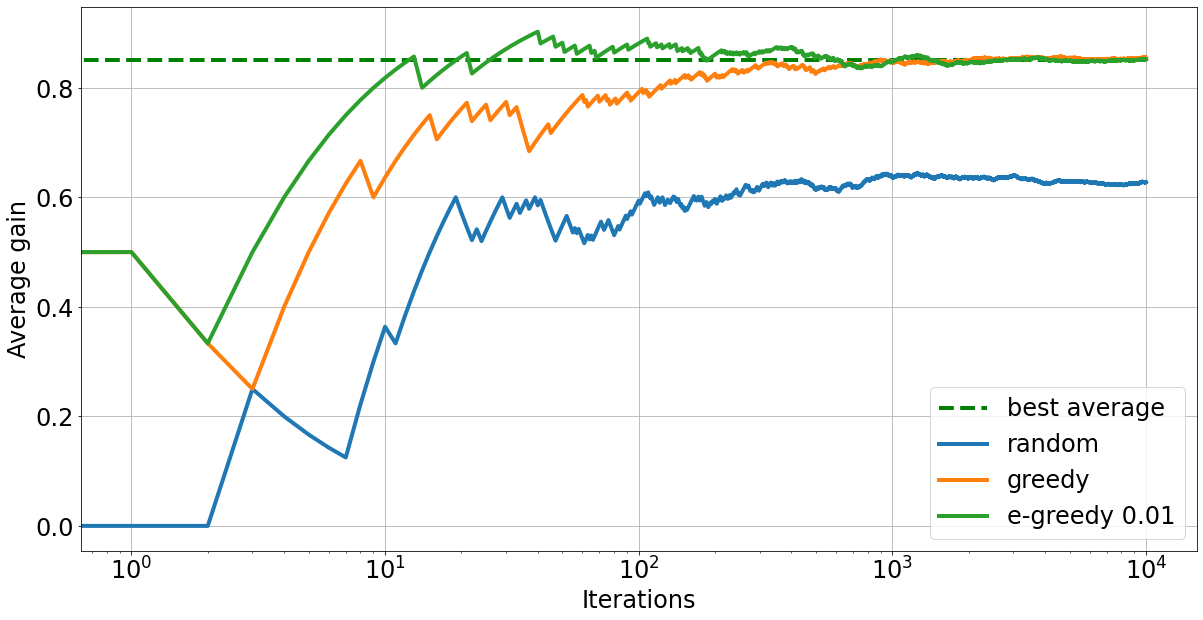

In [113]:
# On trace le gain moyen en fonction des itérations
plt.semilogx([0, n_draws-1], [true_max, true_max], '--g', label='best average')
plt.semilogx(cum_reward_rand / np.arange(1, n_draws+1), label='random')
plt.semilogx(cum_reward_greedy / np.arange(1, n_draws+1), label='greedy')
plt.semilogx(cum_reward_epsilon / np.arange(1, n_draws+1), label='e-greedy 0.01')
plt.xlabel('Iterations')
plt.ylabel('Average gain')
plt.legend()

Avec e = 0.01 l' algo paraît être un peu mieux que l'exploitation pure (greedy) mais ils ont des courbes similaires.

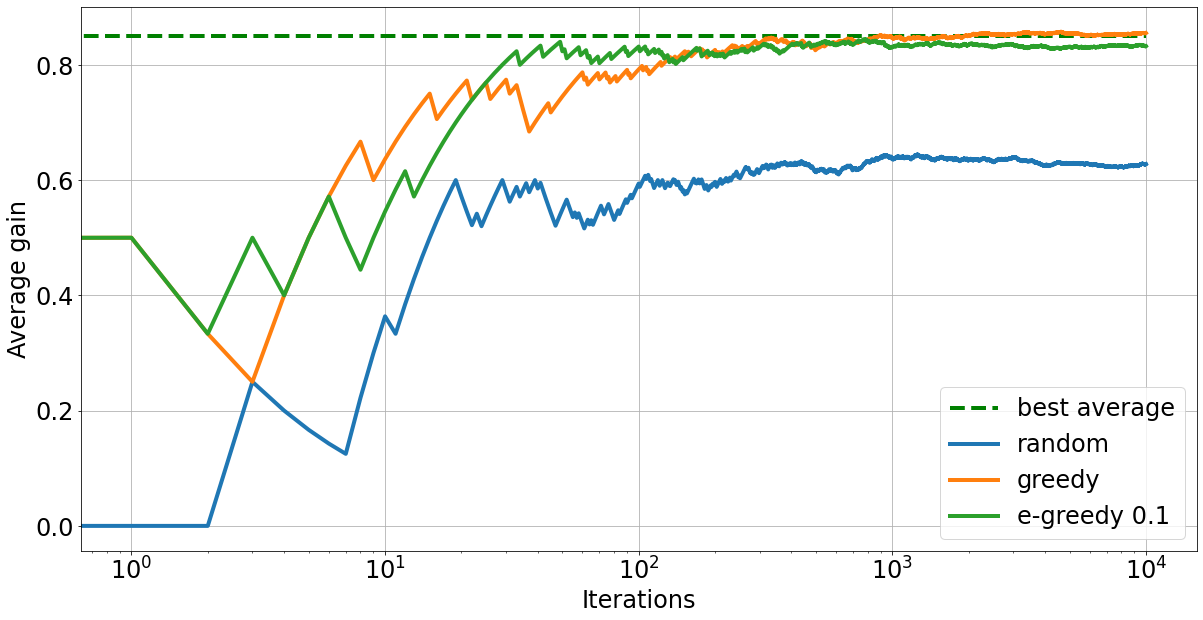

In [111]:
# On trace le gain moyen en fonction des itérations
plt.semilogx([0, n_draws-1], [true_max, true_max], '--g', label='best average')
plt.semilogx(cum_reward_rand / np.arange(1, n_draws+1), label='random')
plt.semilogx(cum_reward_greedy / np.arange(1, n_draws+1), label='greedy')
plt.semilogx(cum_reward_epsilon / np.arange(1, n_draws+1), label='e-greedy 0.1')
plt.xlabel('Iterations')
plt.ylabel('Average gain')
plt.legend()

Quand on augmente la probabilité d'utiliser l'action random, l'algo
devient un peu pire et est jamais arrivé au mieux gain moyenne (best average).

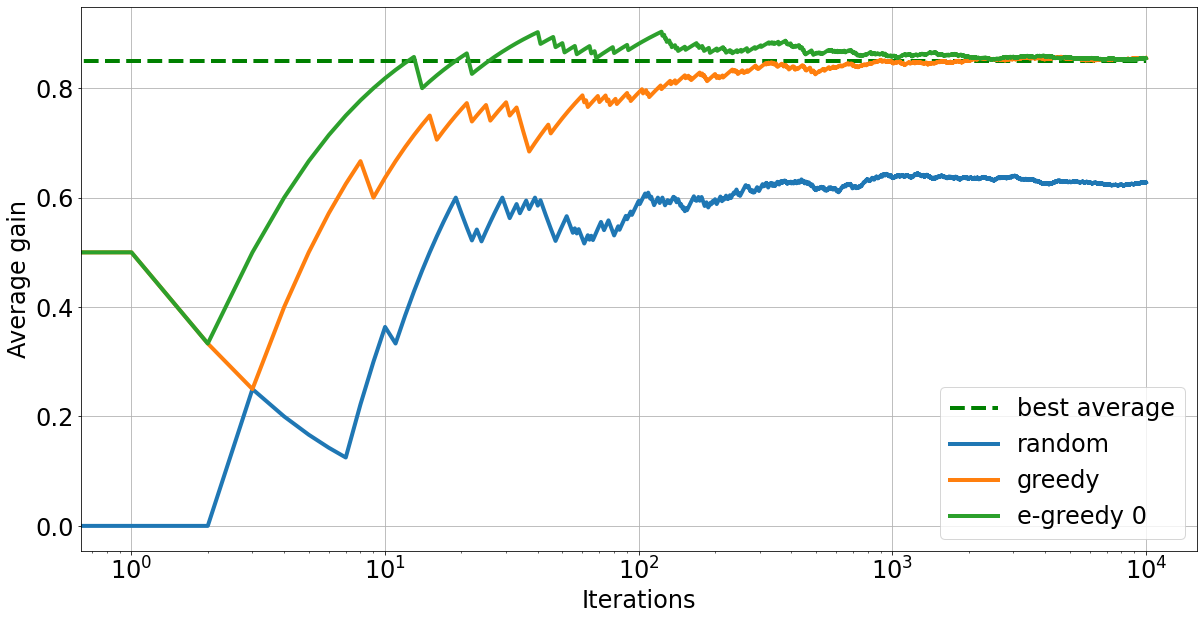

In [116]:
# On trace le gain moyen en fonction des itérations
plt.semilogx([0, n_draws-1], [true_max, true_max], '--g', label='best average')
plt.semilogx(cum_reward_rand / np.arange(1, n_draws+1), label='random')
plt.semilogx(cum_reward_greedy / np.arange(1, n_draws+1), label='greedy')
plt.semilogx(cum_reward_epsilon / np.arange(1, n_draws+1), label='e-greedy 0')
plt.xlabel('Iterations')
plt.ylabel('Average gain')
plt.legend()

Avec e = 0, l'algo est la pure exploitation et sa courbe de gain moyenne ce semble à celle avec e = 0.01 (plus proche de 0 aussi). Il est intéressant que dans cette cas spécifique l'algo e-greedy avec e = 0 parait mieux que l'algo greedy pure, quand en théorie ils devaient avoir la même courbe. La chance avec l'acquisition des récompenses au début d'exécution du algo paraît causer des petites différences.

In [ ]:
# Correction
try:
    from exp_correction import exp_epsgreedy_1
    exp_epsgreedy_1(my_vars)
except:
    print("Ignorer cette cellule, elle ne sert qu'à l'enseignant!")

In [ ]:
# Correction
try:
    exp_correction.exp_epsgreedy_50(my_vars)
except:
    print("Ignorer cette cellule, elle ne sert qu'à l'enseignant!")

 # Stratégie UCB

**À faire.** Complétez les méthodes `fit_step` et `get_action` de la classe `UcbBanditAlgorithm`, réalisez l'expérience précédente dans le cas de la stratégie UCB et tracez les résultats de toutes les stratégies en les superposant.

##### Tests

In [141]:
# Création de l'algo
ucb_algo = bandits.UcbBanditAlgorithm(n_arms=bandits_pb.n_arms, c = 2)  
# On choisit un bras et on observe la récompense, le tout 15 fois
for i in range(15):
    i_arm, ucbs = ucb_algo.get_action()  # Choix du bras par l'algo
    r = bandits_pb.step(i_arm)  # Récompense obtenue
    ucb_algo.fit_step(action=i_arm, reward=r)  # mise à jour de l'algo
    print('Bras {} -> récompense {}'.format(i_arm, r))

t 0
Bras 0 -> récompense False
t 1
Bras 1 -> récompense True
t 2
Bras 2 -> récompense True
t 3
Bras 3 -> récompense False
t 4
Bras 1 -> récompense True
t 5
Bras 2 -> récompense True
t 6
Bras 1 -> récompense True
t 7
Bras 2 -> récompense True
t 8
Bras 0 -> récompense False
t 9
Bras 3 -> récompense True
t 10
Bras 1 -> récompense True
t 11
Bras 2 -> récompense True
t 12
Bras 3 -> récompense True
t 13
Bras 1 -> récompense True
t 14
Bras 2 -> récompense False


In [183]:
# Une simulation sur un grand nombre d'itérations
np.random.seed(8)
ucb_algo = bandits.UcbBanditAlgorithm(n_arms=bandits_pb.n_arms, c = 1) # c = 1
rewards_ucb = np.empty(n_draws)
selected_arms_ucb = np.empty(n_draws)
ucbs_all = [] # upper confidence bound for each arm in each iteration
for i in range(n_draws):
    i_arm, ucbs = ucb_algo.get_action()  # Choix du bras par l'algo
    r = bandits_pb.step(i_arm)  # Récompense obtenue
    ucb_algo.fit_step(action=i_arm, reward=r)  # mise à jour de l'algo
    rewards_ucb[i] = r
    selected_arms_ucb[i] = i_arm
    ucbs_all.append(ucbs)

# Calcul du regret sur une simu
r_max = np.max(ucb_algo._value_estimates)  # Gain moyen du bras optimal au fin du simu (on utilize Q, pas true_values)
cum_reward_ucb = np.cumsum(rewards_ucb)  # Récompenses cumulées
regret_ucb = np.arange(1, n_draws+1) * r_max - cum_reward_ucb# Regret random
best_arm = np.argmax(ucbs_all[n_draws-1])

In [184]:
best_arm

1

**À faire.** Pour UCB, tracez, en fonction des itérations, la moyenne et la borne supérieure de chaque bras en superposant les courbes sur un unique graphique (dans le même esprit que dans le cours). Analysez la figure obtenue.

[0.         0.         0.         ... 0.88197702 0.88198091 0.88198479]
[0.         0.         0.         ... 0.89581514 0.89583447 0.89585379]
[0.         0.         0.         ... 0.8953432  0.89534438 0.89534556]
[0.         0.         0.         ... 0.89560005 0.89560033 0.89560062]


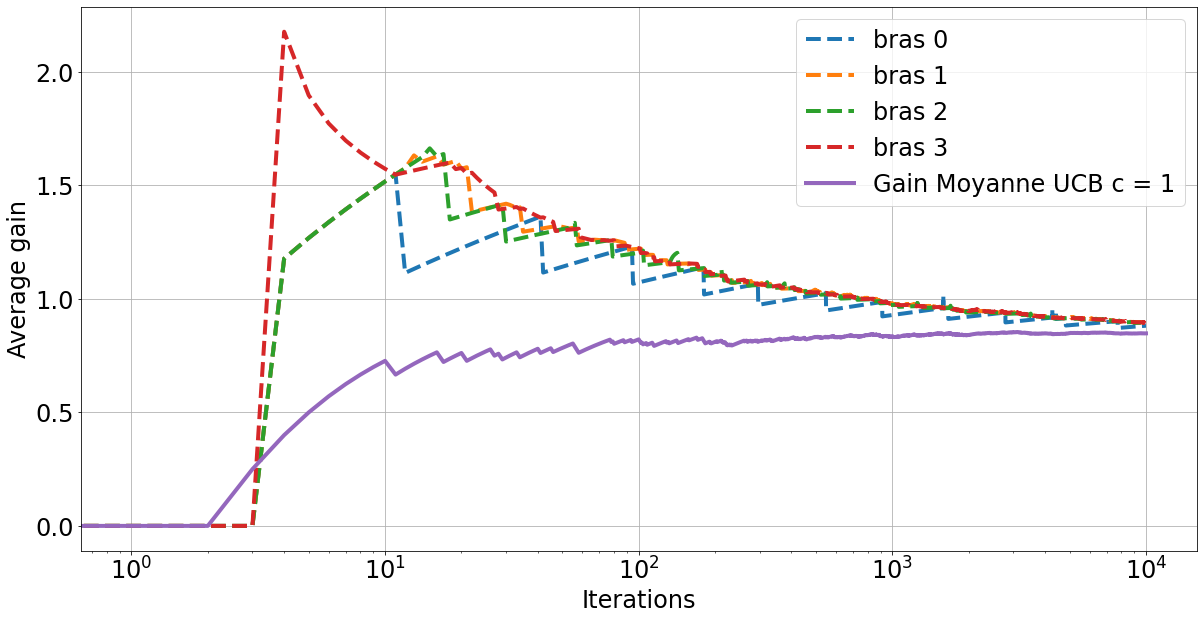

In [185]:
for i in range(bandits_pb.n_arms):
    ucb_armi = np.empty(n_draws)
    for d in range(n_draws):
        ucb = ucbs_all[d][i]
        if ucb == 'inf':
            ucb = 0
        ucb_armi[d] = ucb
    print(ucb_armi)
    plt.semilogx(ucb_armi ,'--', label='bras '+str(i)) #/ np.arange(1, n_draws+1)
# On trace le gain moyen en fonction des itérations
#plt.semilogx([0, n_draws-1], [best_arm, true_max], '--g', label='Bras Optimal au fin')
plt.semilogx(cum_reward_ucb/np.arange(1, n_draws+1), label='Gain Moyanne UCB c = 1')

#plt.semilogx(ucbs_all[1] / np.arange(1, n_draws+1), label='bras 0')
plt.xlabel('Iterations')
plt.ylabel('Average gain')
plt.legend()

L'algo UCB balance entre exploitation et exploration en permettant qui les bras moins explorés ont un ucb mayeur au début mais aussi qui les bras avec la récompense moyenne q(a) plus grande dépassent au fin (confidence plus grande aussi). Au final, tous les bras ont un ucb très proche mais le bras optimal choisi est 1, qui est le meilleur. 

In [ ]:
# Correction
try:
    exp_correction.exp_ucb(my_vars)
except:
    print("Ignorer cette cellule, elle ne sert qu'à l'enseignant!")

In [ ]:
# Correction
try:
    exp_correction.exp_ucb_tracking(my_vars)
except:
    print("Ignorer cette cellule, elle ne sert qu'à l'enseignant!")

 # Stratégie thompson Sampling
 **À faire (séance 2).** Complétez les méthodes `fit_step` et `get_action` de la classe `ThompsonSamplingAlgorithm`, réalisez l'expérience précédente dans le cas de la stratégie thompson Sampling et tracez les résultats de toutes les stratégies en les superposant.

In [198]:
# Création de l'algo
thompson_algo = bandits.ThompsonSamplingAlgorithm(n_arms=bandits_pb.n_arms)  
# On choisit un bras et on observe la récompense, le tout 15 fois
for i in range(15):
    i_arm = thompson_algo.get_action()  # Choix du bras par l'algo
    r = bandits_pb.step(i_arm)  # Récompense obtenue
    thompson_algo.fit_step(action=i_arm, reward=r)  # mise à jour de l'algo
    print('Bras {} -> récompense {}'.format(i_arm, r))

Bras 2 -> récompense True
Bras 2 -> récompense False
Bras 3 -> récompense True
Bras 2 -> récompense True
Bras 3 -> récompense True
Bras 0 -> récompense True
Bras 3 -> récompense True
Bras 1 -> récompense True
Bras 1 -> récompense True
Bras 1 -> récompense True
Bras 0 -> récompense False
Bras 3 -> récompense True
Bras 3 -> récompense True
Bras 1 -> récompense True
Bras 1 -> récompense True


In [286]:
# Une simulation sur un grand nombre d'itérations
n_draws = 10**4
np.random.seed(2)
thompson_algo = bandits.ThompsonSamplingAlgorithm(n_arms=bandits_pb.n_arms) 
rewards_thompson = np.empty(n_draws)
selected_arms_thompson = np.empty(n_draws)

alphas = []
betas = []

for i in range(n_draws):
    i_arm,alpha, beta = thompson_algo.get_action()  # Choix du bras par l'algo
    r = bandits_pb.step(i_arm)  # Récompense obtenue
    thompson_algo.fit_step(action=i_arm, reward=r)  # mise à jour de l'algo
    rewards_thompson[i] = r
    selected_arms_thompson[i] = i_arm
    #print(alpha,beta)
    alphas.append(np.array(alpha))
    betas.append(np.array(beta))
    
# Calcul du regret sur une simu
#r_max = np.max(thompson_algo._value_estimates)  # Gain moyen du bras optimal au fin du simu (on utilize Q, pas true_values)
cum_reward_thompson = np.cumsum(rewards_thompson)  # Récompenses cumulées
# regret_ucb = np.arange(1, n_draws+1) * r_max - cum_reward_thompson# Regret random
best_arm,a,b = thompson_algo.get_action()

In [287]:
best_arm 

3

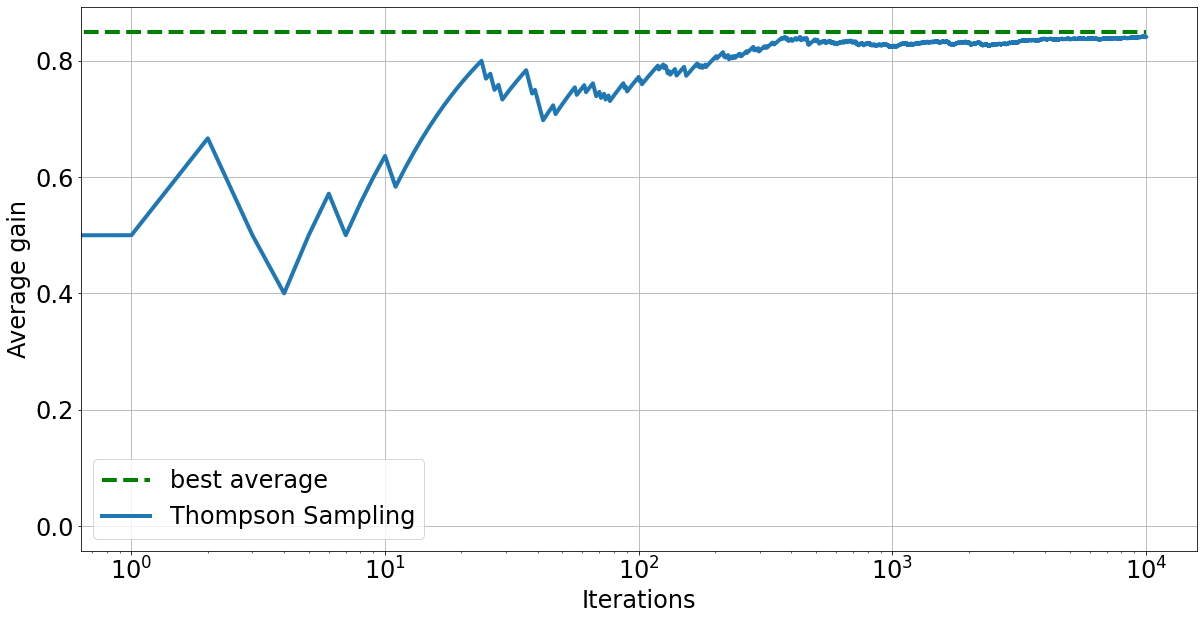

In [288]:
# On trace le gain moyen en fonction des itérations
plt.semilogx([0, n_draws-1], [true_max, true_max], '--g', label='best average')
plt.semilogx(cum_reward_thompson / np.arange(1, n_draws+1), label='Thompson Sampling')
plt.xlabel('Iterations')
plt.ylabel('Average gain')
plt.legend()

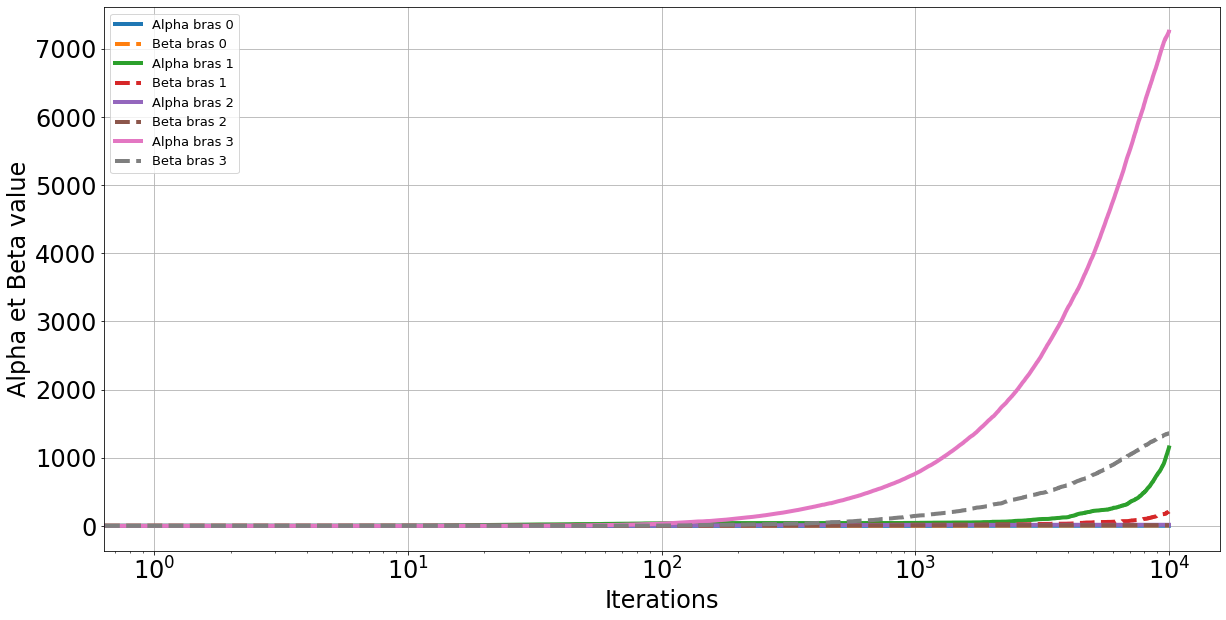

In [289]:
for i in range(bandits_pb.n_arms):
    
    alpha_armi = np.empty(n_draws)
    beta_armi = np.empty(n_draws)
    for d in range(n_draws):
        alpha_armi[d] = alphas[d][i]
        beta_armi[d] = betas[d][i]
        
    plt.semilogx(alpha_armi, label='Alpha bras '+str(i)) #/ np.arange(1, n_draws+1)
    plt.semilogx(beta_armi,'--', label='Beta bras '+str(i))
# On trace le gain moyen en fonction des itérations
#plt.semilogx([0, n_draws-1], [best_arm, true_max], '--g', label='Bras Optimal au fin')
#plt.semilogx(cum_reward_thompson / np.arange(1, n_draws+1), label='TS Moyanne')

#plt.semilogx(ucbs_all[1] / np.arange(1, n_draws+1), label='bras 0')
plt.xlabel('Iterations')
plt.ylabel('Alpha et Beta value')
plt.legend( prop={"size":13})

Text(0.5, 1.0, 'Estimation des valeurs ptheta de chaque bras / iteration')

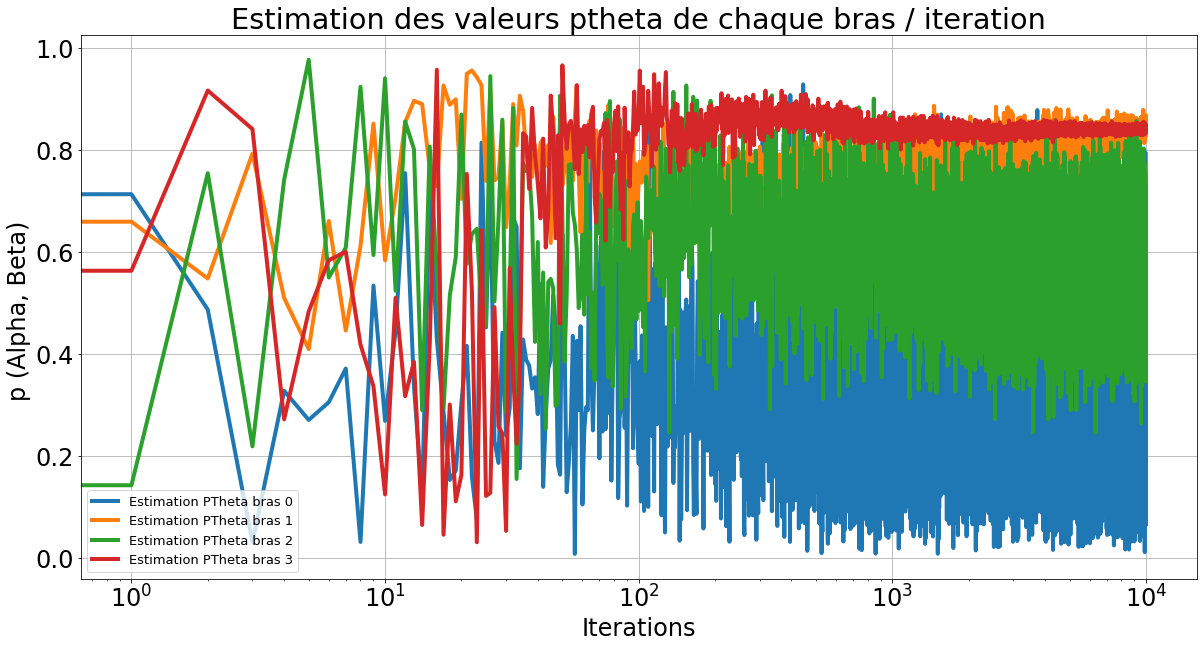

In [291]:
for i in range(bandits_pb.n_arms):
    
    pthetas = []
    for d in range(n_draws):
        ptheta = np.random.beta(alphas[d][i],betas[d][i])
        pthetas.append(ptheta)
        
    plt.semilogx(pthetas, label='Estimation PTheta bras '+str(i)) #/ np.arange(1, n_draws+1)
# On trace le gain moyen en fonction des itérations
#plt.semilogx([0, n_draws-1], [best_arm, true_max], '--g', label='Bras Optimal au fin')
#plt.semilogx(cum_reward_thompson / np.arange(1, n_draws+1), label='TS Moyanne')

#plt.semilogx(ucbs_all[1] / np.arange(1, n_draws+1), label='bras 0')
plt.xlabel('Iterations')
plt.ylabel('p (Alpha, Beta) ')
plt.legend( prop={"size":13})
plt.title("Estimation des valeurs ptheta de chaque bras / iteration")

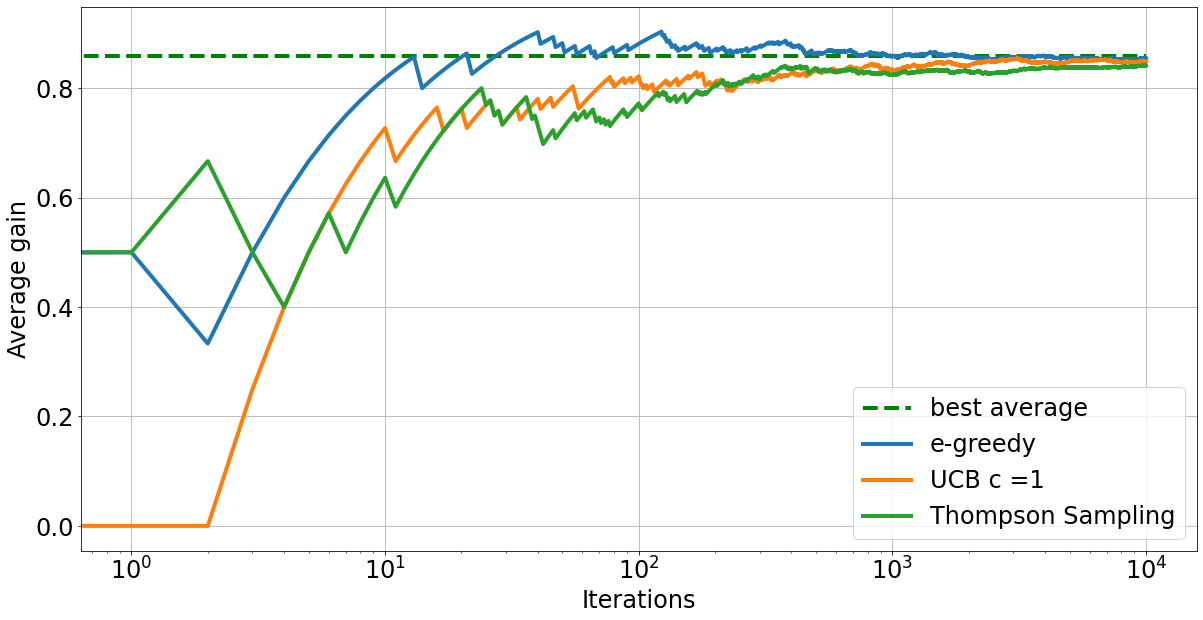

In [292]:
# On trace le gain moyen en fonction des itérations
plt.semilogx([0, n_draws-1], [r_max, r_max], '--g', label='best average')
plt.semilogx(cum_reward_epsilon / np.arange(1, n_draws+1), label='e-greedy')
plt.semilogx(cum_reward_ucb / np.arange(1, n_draws+1), label='UCB c =1')
plt.semilogx(cum_reward_thompson / np.arange(1, n_draws+1), label='Thompson Sampling')
plt.xlabel('Iterations')
plt.ylabel('Average gain')
plt.legend()

In [ ]:
# Correction
try:
    exp_correction.exp_ts(my_vars)
except:
    print("Ignorer cette cellule, elle ne sert qu'à l'enseignant!")